<a href="https://colab.research.google.com/github/iamjustkay/Recommendation_System/blob/main/Recommendation_System_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install implicit lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 102.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from collections import Counter

In [3]:
# Try importing implicit (ALS)
try:
    import implicit
except ImportError:
    implicit = None

In [4]:
# -------------------------------
# Step 1: Load & Clean Data
# -------------------------------
def clean_value(val):
    """Convert 'n123' -> 123 (int), keep others unchanged."""
    if isinstance(val, str) and val.startswith("n"):
        try:
            return int(val[1:])
        except ValueError:
            return val
    return val

MAX_EVENTS = None  # limit for demo speed

In [5]:
# Load events
events = pd.read_csv("/content/events_cleaned.csv", nrows=MAX_EVENTS)

# Load and clean item_properties
item_props = pd.read_csv("/content/item_props_cleaned_n.csv",
                         names=["timestamp", "itemid", "property", "value"],
                         skiprows=1) # Skip the header row
item_props["value"] = item_props["value"].apply(clean_value)

# Load category_tree
category_tree = pd.read_csv("/content/category_tree_cleaned.csv",
                            names=["child", "parent"])

print(f"Events shape: {events.shape}")
print(f"Item properties shape: {item_props.shape}")
print(f"Category tree shape: {category_tree.shape}")

Events shape: (2211748, 5)
Item properties shape: (1103288, 4)
Category tree shape: (1670, 2)


In [6]:
# -------------------------------
# Step 2: Candidate Generation
# -------------------------------
def build_user_item_matrix(events_df):
    weight_map = {"view": 1.0, "addtocart": 3.0, "transaction": 5.0}
    events_df["weight"] = events_df["event"].map(weight_map).fillna(1.0)
    user_enc = LabelEncoder()
    item_enc = LabelEncoder()
    events_df["user_idx"] = user_enc.fit_transform(events_df["visitorid"])
    events_df["item_idx"] = item_enc.fit_transform(events_df["itemid"])
    rows, cols, vals = events_df["user_idx"].values, events_df["item_idx"].values, events_df["weight"].values
    ui_matrix = sparse.coo_matrix((vals, (rows, cols)),
                                  shape=(len(user_enc.classes_), len(item_enc.classes_)))
    return ui_matrix.tocsr(), user_enc, item_enc

ui_matrix, user_enc, item_enc = build_user_item_matrix(events)

In [7]:
# Popular items baseline
def top_popular(events_df, k=10):
    return events_df["itemid"].value_counts().head(k).index.tolist()

print("Top popular items:", top_popular(events, 10))


Top popular items: [187946, 5411, 370653, 461686, 298009, 96924, 219512, 384302, 335975, 441668]


In [8]:
# ALS recommendations (if implicit is installed)
if implicit is not None:
    als_model = implicit.als.AlternatingLeastSquares(factors=32, iterations=5)
    als_model.fit(ui_matrix.T)
    user0_recs = als_model.recommend(0, ui_matrix[0], N=5)
    print("ALS recs for first user:", user0_recs)
else:
    print("implicit not installed, skipping ALS.")


/usr/local/lib/python3.11/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.06716609001159668 seconds
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

ALS recs for first user: (array([280275, 542991, 337384, 702599, 755570], dtype=int32), array([1.2942248e-08, 1.1487362e-08, 1.0668844e-08, 1.0632926e-08,
       9.9679021e-09], dtype=float32))


In [9]:
# -------------------------------
# Step 3: Evaluation Metrics
# -------------------------------
def recall_at_k(true_items, pred_items, k):
    return len(set(pred_items[:k]) & set(true_items)) / max(1, len(set(true_items)))

def hit_rate_at_k(true_items, pred_items, k):
    return int(len(set(pred_items[:k]) & set(true_items)) > 0)

def ndcg_at_k(true_items, pred_items, k):
    def dcg(scores):
        return sum((2**s - 1) / np.log2(i+2) for i, s in enumerate(scores))
    rels = [1 if p in true_items else 0 for p in pred_items[:k]]
    return dcg(rels) / max(dcg(sorted(rels, reverse=True)), 1e-9)

In [10]:
# -------------------------------
# Task 1 - Deep Learning Model (Tuned CNN Only)
# -------------------------------
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from collections import Counter

# --- Step 1: Prepare data ---
target_prop = item_props["property"].value_counts().index[0]
print("Target property for prediction:", target_prop)

# Build item->latest value for target_prop
prop_df = item_props[item_props["property"] == target_prop].sort_values("timestamp")
item_latest_prop = prop_df.groupby("itemid")["value"].last().to_dict()

X_texts, y_labels = [], []
for _, row in events[events["event"] == "addtocart"].iterrows():
    user_hist = events[(events["visitorid"] == row["visitorid"]) &
                       (events["timestamp"] < row["timestamp"]) &
                       (events["event"] == "view")]
    tokens = [str(item_latest_prop.get(i, "")) for i in user_hist["itemid"].values]
    label = item_latest_prop.get(row["itemid"])
    if label and tokens:
        X_texts.append(" ".join(tokens))
        y_labels.append(label)

# Filter to frequent classes only (adaptive min frequency)
counts = Counter(y_labels)
min_freq = 10  # lower to keep more classes for small samples
top_classes = {cls for cls, cnt in counts.items() if cnt >= min_freq}
filtered = [(txt, lbl) for txt, lbl in zip(X_texts, y_labels) if lbl in top_classes]

if not filtered:
    print("No training samples found after filtering.")
else:
    X_texts, y_labels = zip(*filtered)
    X_texts, y_labels = list(X_texts), list(y_labels)

    # Encode labels
    label_enc = LabelEncoder()
    y_enc = label_enc.fit_transform(y_labels)
    num_classes = len(label_enc.classes_)

    # Tokenize & pad sequences
    max_words = 5000
    max_len = 50
    tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_texts)
    X_seq = tokenizer.texts_to_sequences(X_texts)
    X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post')

    # Train/test split
    X_train, X_val, y_train, y_val = train_test_split(X_pad, y_enc, test_size=0.2, random_state=42)

    # Convert to categorical
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

    # --- Step 2: Define Tuned CNN ---
    def build_cnn():
        model = tf.keras.Sequential([
            tf.keras.layers.Embedding(max_words, 128, input_length=max_len),
            tf.keras.layers.Conv1D(256, 5, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling1D(2),
            tf.keras.layers.Conv1D(128, 5, activation='relu'),
            tf.keras.layers.GlobalMaxPooling1D(),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        model.compile(
            loss='categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
            metrics=['accuracy']
        )
        return model

    # --- Step 3: Train CNN ---
    cnn_model = build_cnn()
    early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

    history = cnn_model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=8,
        batch_size=64,
        callbacks=[early_stop],
        verbose=1
    )

    # --- Step 4: Evaluate ---
    loss, acc = cnn_model.evaluate(X_val, y_val_cat, verbose=0)
    print(f"Tuned CNN Validation Accuracy: {acc:.4f}")

Target property for prediction: 790
Epoch 1/8


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.0300 - loss: 4.7718 - val_accuracy: 0.0313 - val_loss: 4.7902
Epoch 2/8
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.0902 - loss: 4.5766 - val_accuracy: 0.0598 - val_loss: 4.7758
Epoch 3/8
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.1201 - loss: 4.0681 - val_accuracy: 0.1197 - val_loss: 4.7339
Epoch 4/8
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.2541 - loss: 3.3114 - val_accuracy: 0.2564 - val_loss: 4.6517
Epoch 5/8
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - accuracy: 0.5366 - loss: 2.2816 - val_accuracy: 0.5299 - val_loss: 4.4964
Epoch 6/8
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.7704 - loss: 1.2180 - val_accuracy: 0.7749 - val_loss: 4.2867
Epoch 7/8
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.8829 - loss: 0.6410 - val_accuracy: 0.8803 - val_loss: 4.0977
Epoch 8/8
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9181 - loss: 0.4551 - val_accuracy: 0.9088 - val_loss: 3

Epoch 1/20
34487/34487 ━━━━━━━━━━━━━━━━━━━━ 97s 3ms/step - loss: 0.0671 - val_loss: 3.8123e-04
Epoch 2/20
34487/34487 ━━━━━━━━━━━━━━━━━━━━ 143s 3ms/step - loss: 0.0027 - val_loss: 3.4738e-04
Epoch 3/20
34487/34487 ━━━━━━━━━━━━━━━━━━━━ 94s 3ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 4/20
34487/34487 ━━━━━━━━━━━━━━━━━━━━ 102s 3ms/step - loss: 0.0014 - val_loss: 1.3368e-04
Epoch 5/20
34487/34487 ━━━━━━━━━━━━━━━━━━━━ 93s 3ms/step - loss: 0.0012 - val_loss: 8.1550e-05
Epoch 6/20
34487/34487 ━━━━━━━━━━━━━━━━━━━━ 95s 3ms/step - loss: 0.0011 - val_loss: 2.2312e-04
Epoch 7/20
34487/34487 ━━━━━━━━━━━━━━━━━━━━ 93s 3ms/step - loss: 8.4970e-04 - val_loss: 4.4650e-05
Epoch 8/20
34487/34487 ━━━━━━━━━━━━━━━━━━━━ 103s 3ms/step - loss: 5.3531e-04 - val_loss: 8.3948e-05
Epoch 9/20
34487/34487 ━━━━━━━━━━━━━━━━━━━━ 143s 3ms/step - loss: 6.2231e-04 - val_loss: 6.7054e-05
43109/43109 ━━━━━━━━━━━━━━━━━━━━ 52s 1ms/step
Detected outliers: 21073 users


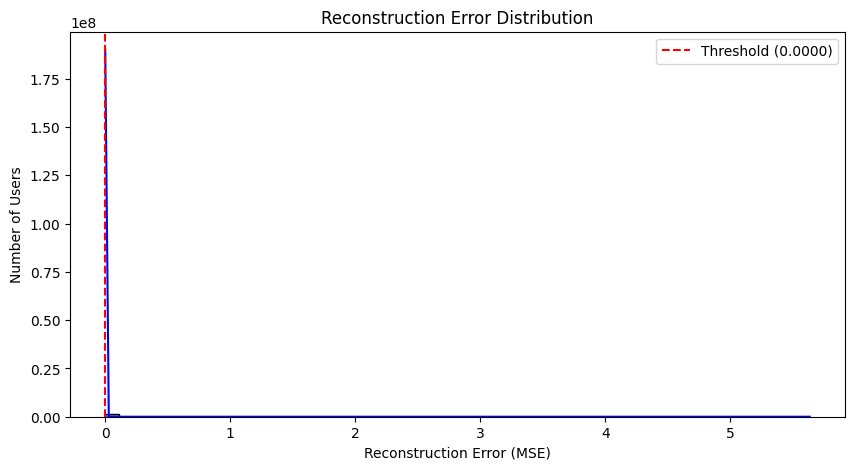

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


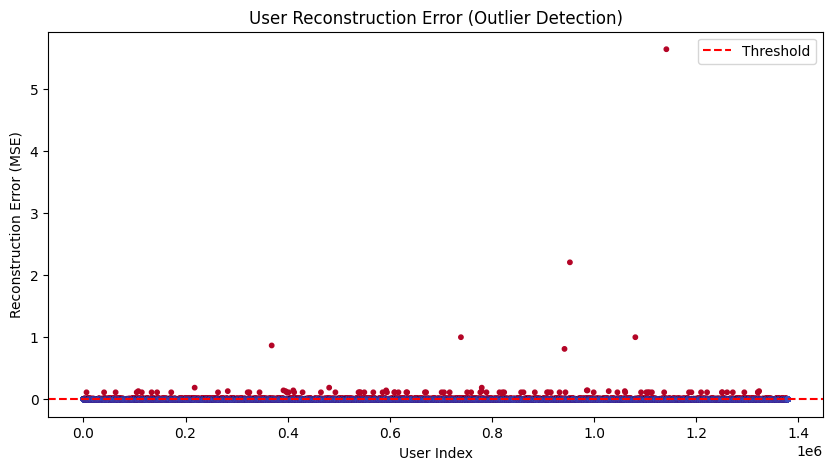

In [11]:
# -------------------------------
# Task 2 - Abnormal User Detection (CNN Autoencoder + Visualization)
# -------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# --- Step 1: Build user-level features ---
def build_user_features(events_df):
    feats = []
    for uid, g in events_df.groupby("visitorid"):
        total = len(g)
        views = (g["event"] == "view").sum()
        adds = (g["event"] == "addtocart").sum()
        buys = (g["event"] == "transaction").sum()
        feats.append({
            "visitorid": uid,
            "total_events": total,
            "views": views,
            "adds": adds,
            "buys": buys,
            "add_rate": adds/total if total > 0 else 0,
            "conv_rate": buys/total if total > 0 else 0
        })
    return pd.DataFrame(feats).set_index("visitorid")

user_feats = build_user_features(events)

# --- Step 2: Scale features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(user_feats)

# Reshape for CNN (samples, timesteps, channels)
X_cnn = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# --- Step 3: Define CNN Autoencoder ---
def build_cnn_autoencoder(seq_len):
    input_layer = tf.keras.layers.Input(shape=(seq_len, 1))
    x = tf.keras.layers.Conv1D(32, 2, activation='relu', padding='same')(input_layer)
    x = tf.keras.layers.MaxPooling1D(2, padding='same')(x)
    x = tf.keras.layers.Conv1D(16, 2, activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling1D(2)(x)
    x = tf.keras.layers.Conv1D(32, 2, activation='relu', padding='same')(x)
    decoded = tf.keras.layers.Conv1D(1, 2, activation='linear', padding='same')(x)
    model = tf.keras.models.Model(inputs=input_layer, outputs=decoded)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

cnn_autoencoder = build_cnn_autoencoder(X_cnn.shape[1])

# --- Step 4: Train autoencoder ---
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = cnn_autoencoder.fit(
    X_cnn, X_cnn,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# --- Step 5: Reconstruction error ---
reconstructions = cnn_autoencoder.predict(X_cnn)
mse = np.mean(np.power(X_cnn - reconstructions, 2), axis=(1, 2))
threshold = np.percentile(mse, 98)  # top 2% anomaly threshold

user_feats["reconstruction_error"] = mse
user_feats["outlier"] = (mse > threshold).astype(int)
print(f"Detected outliers: {user_feats['outlier'].sum()} users")



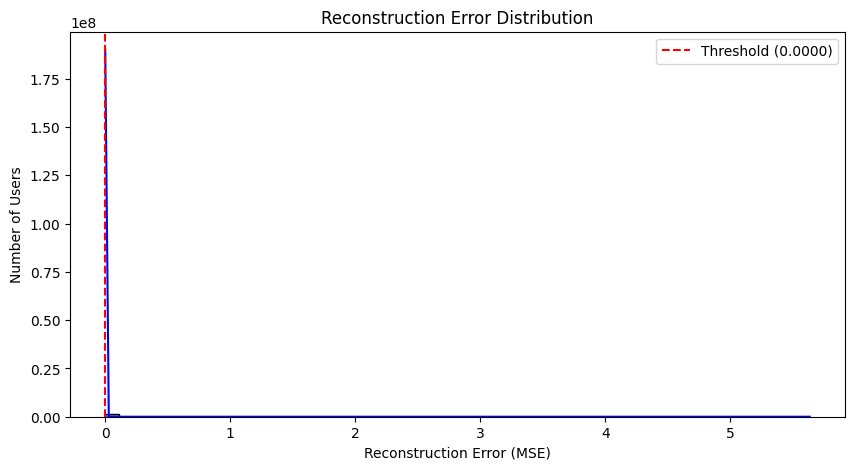

In [12]:
# --- Step 6: Visualization ---
plt.figure(figsize=(10,5))
sns.histplot(mse, bins=50, kde=True, color='blue')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.4f})')
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Number of Users")
plt.legend()
plt.show()



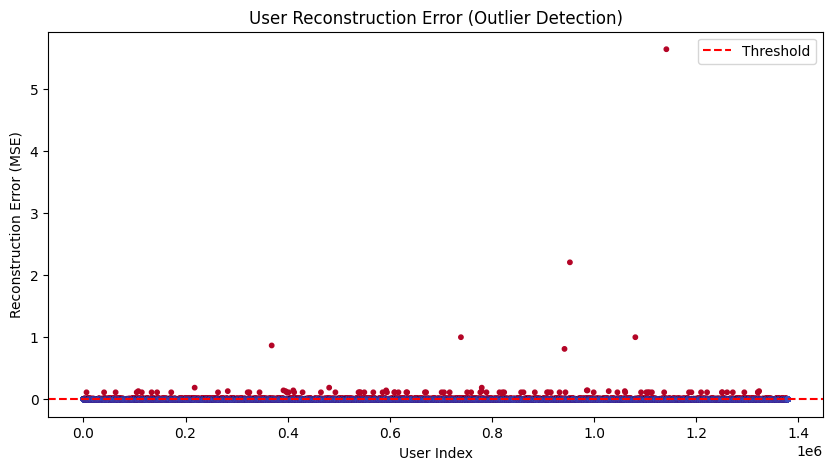

In [13]:
# Scatter plot for better view
plt.figure(figsize=(10,5))
plt.scatter(range(len(mse)), mse, c=(mse > threshold), cmap='coolwarm', s=10)
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("User Reconstruction Error (Outlier Detection)")
plt.xlabel("User Index")
plt.ylabel("Reconstruction Error (MSE)")
plt.legend()
plt.show()
